In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels))
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
                                                                     labels=tf.ones_like(rates))) # min
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                #rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              #model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:0.6807 eloss:3.1423 aloss2:2.0976 exploreP:0.9983
Episode:1 meanR:24.0000 R:31.0000 rate:0.0620 aloss:0.6806 eloss:3.1500 aloss2:2.0648 exploreP:0.9953
Episode:2 meanR:20.6667 R:14.0000 rate:0.0280 aloss:0.6833 eloss:3.1730 aloss2:2.0389 exploreP:0.9939
Episode:3 meanR:23.2500 R:31.0000 rate:0.0620 aloss:0.6824 eloss:3.1564 aloss2:2.0330 exploreP:0.9908
Episode:4 meanR:24.0000 R:27.0000 rate:0.0540 aloss:0.6867 eloss:3.1494 aloss2:2.0209 exploreP:0.9882
Episode:5 meanR:23.0000 R:18.0000 rate:0.0360 aloss:0.6794 eloss:3.1523 aloss2:2.0260 exploreP:0.9864
Episode:6 meanR:21.2857 R:11.0000 rate:0.0220 aloss:0.6793 eloss:3.1563 aloss2:2.0169 exploreP:0.9854
Episode:7 meanR:20.5000 R:15.0000 rate:0.0300 aloss:0.6848 eloss:3.1228 aloss2:2.0260 exploreP:0.9839
Episode:8 meanR:21.2222 R:27.0000 rate:0.0540 aloss:0.6980 eloss:3.1274 aloss2:2.0240 exploreP:0.9813
Episode:9 meanR:25.1000 R:60.0000 rate:0.1200 aloss:0.6866 eloss:3.1087 aloss2:2.0

Episode:80 meanR:21.7407 R:13.0000 rate:0.0260 aloss:0.7558 eloss:1.8605 aloss2:3.6692 exploreP:0.8401
Episode:81 meanR:21.7805 R:25.0000 rate:0.0500 aloss:0.7072 eloss:1.7896 aloss2:3.7140 exploreP:0.8381
Episode:82 meanR:21.9036 R:32.0000 rate:0.0640 aloss:0.7328 eloss:1.8687 aloss2:3.5431 exploreP:0.8354
Episode:83 meanR:21.8690 R:19.0000 rate:0.0380 aloss:0.7159 eloss:1.7880 aloss2:3.7054 exploreP:0.8339
Episode:84 meanR:21.7529 R:12.0000 rate:0.0240 aloss:0.7246 eloss:1.8371 aloss2:3.6736 exploreP:0.8329
Episode:85 meanR:21.6279 R:11.0000 rate:0.0220 aloss:0.7068 eloss:1.7874 aloss2:3.8832 exploreP:0.8320
Episode:86 meanR:21.6092 R:20.0000 rate:0.0400 aloss:0.7253 eloss:1.7964 aloss2:3.7119 exploreP:0.8303
Episode:87 meanR:21.5114 R:13.0000 rate:0.0260 aloss:0.7380 eloss:1.7774 aloss2:3.8304 exploreP:0.8293
Episode:88 meanR:21.4607 R:17.0000 rate:0.0340 aloss:0.7654 eloss:1.8255 aloss2:3.5252 exploreP:0.8279
Episode:89 meanR:21.3333 R:10.0000 rate:0.0200 aloss:0.7046 eloss:1.7817 

Episode:160 meanR:18.8400 R:29.0000 rate:0.0580 aloss:0.7257 eloss:1.3983 aloss2:5.4527 exploreP:0.7226
Episode:161 meanR:18.7700 R:12.0000 rate:0.0240 aloss:0.7888 eloss:1.3924 aloss2:5.3324 exploreP:0.7217
Episode:162 meanR:18.6600 R:11.0000 rate:0.0220 aloss:0.7032 eloss:1.3513 aloss2:6.5093 exploreP:0.7210
Episode:163 meanR:18.6600 R:16.0000 rate:0.0320 aloss:0.7239 eloss:1.3512 aloss2:5.5914 exploreP:0.7198
Episode:164 meanR:18.7200 R:19.0000 rate:0.0380 aloss:0.7208 eloss:1.4083 aloss2:5.5178 exploreP:0.7185
Episode:165 meanR:18.9700 R:40.0000 rate:0.0800 aloss:0.7283 eloss:1.3272 aloss2:5.8515 exploreP:0.7156
Episode:166 meanR:18.9400 R:20.0000 rate:0.0400 aloss:0.7577 eloss:1.3354 aloss2:5.4752 exploreP:0.7142
Episode:167 meanR:18.6800 R:11.0000 rate:0.0220 aloss:0.7610 eloss:1.2723 aloss2:5.7250 exploreP:0.7135
Episode:168 meanR:18.6200 R:12.0000 rate:0.0240 aloss:0.7226 eloss:1.3016 aloss2:5.6079 exploreP:0.7126
Episode:169 meanR:18.7600 R:29.0000 rate:0.0580 aloss:0.7186 elo

Episode:239 meanR:46.5000 R:105.0000 rate:0.2100 aloss:0.7100 eloss:1.2930 aloss2:6.8120 exploreP:0.4753
Episode:240 meanR:46.6300 R:30.0000 rate:0.0600 aloss:0.7519 eloss:1.2931 aloss2:6.8345 exploreP:0.4739
Episode:241 meanR:47.7200 R:121.0000 rate:0.2420 aloss:0.7042 eloss:1.2735 aloss2:6.8543 exploreP:0.4683
Episode:242 meanR:48.9100 R:130.0000 rate:0.2600 aloss:0.7128 eloss:1.2778 aloss2:6.6880 exploreP:0.4624
Episode:243 meanR:48.9300 R:27.0000 rate:0.0540 aloss:0.7057 eloss:1.2407 aloss2:6.6382 exploreP:0.4612
Episode:244 meanR:50.6200 R:187.0000 rate:0.3740 aloss:0.7158 eloss:1.2515 aloss2:6.8729 exploreP:0.4528
Episode:245 meanR:52.2600 R:183.0000 rate:0.3660 aloss:0.7215 eloss:1.2604 aloss2:6.7926 exploreP:0.4448
Episode:246 meanR:52.9700 R:83.0000 rate:0.1660 aloss:0.7180 eloss:1.2812 aloss2:6.7594 exploreP:0.4412
Episode:247 meanR:55.3900 R:265.0000 rate:0.5300 aloss:0.7085 eloss:1.3108 aloss2:6.6812 exploreP:0.4299
Episode:248 meanR:56.5300 R:128.0000 rate:0.2560 aloss:0.7

Episode:317 meanR:141.2800 R:58.0000 rate:0.1160 aloss:0.7448 eloss:1.3452 aloss2:6.2014 exploreP:0.1487
Episode:318 meanR:140.6000 R:50.0000 rate:0.1000 aloss:0.7591 eloss:1.3907 aloss2:6.2782 exploreP:0.1480
Episode:319 meanR:140.3600 R:39.0000 rate:0.0780 aloss:0.7686 eloss:1.4415 aloss2:6.2354 exploreP:0.1475
Episode:320 meanR:139.6800 R:38.0000 rate:0.0760 aloss:0.7370 eloss:1.4216 aloss2:6.2099 exploreP:0.1470
Episode:321 meanR:137.5400 R:32.0000 rate:0.0640 aloss:0.7555 eloss:1.5345 aloss2:6.1899 exploreP:0.1465
Episode:322 meanR:138.0400 R:89.0000 rate:0.1780 aloss:0.7539 eloss:1.3962 aloss2:6.1935 exploreP:0.1453
Episode:323 meanR:137.1200 R:37.0000 rate:0.0740 aloss:0.7553 eloss:1.2931 aloss2:6.2050 exploreP:0.1448
Episode:324 meanR:136.1000 R:64.0000 rate:0.1280 aloss:0.8220 eloss:1.3679 aloss2:6.2251 exploreP:0.1440
Episode:325 meanR:135.0400 R:31.0000 rate:0.0620 aloss:0.7747 eloss:1.2393 aloss2:6.2434 exploreP:0.1435
Episode:326 meanR:135.4600 R:60.0000 rate:0.1200 aloss:

Episode:396 meanR:68.1100 R:90.0000 rate:0.1800 aloss:0.7419 eloss:1.5148 aloss2:6.1765 exploreP:0.0895
Episode:397 meanR:67.5700 R:76.0000 rate:0.1520 aloss:0.7760 eloss:1.3045 aloss2:6.1539 exploreP:0.0889
Episode:398 meanR:67.7200 R:85.0000 rate:0.1700 aloss:0.7734 eloss:1.3556 aloss2:6.1771 exploreP:0.0882
Episode:399 meanR:67.7600 R:59.0000 rate:0.1180 aloss:0.7583 eloss:1.4517 aloss2:6.2126 exploreP:0.0878
Episode:400 meanR:67.8100 R:112.0000 rate:0.2240 aloss:0.7417 eloss:1.5012 aloss2:6.1599 exploreP:0.0869
Episode:401 meanR:68.2900 R:118.0000 rate:0.2360 aloss:0.7214 eloss:1.4162 aloss2:6.1347 exploreP:0.0860
Episode:402 meanR:68.4800 R:109.0000 rate:0.2180 aloss:0.7731 eloss:1.3868 aloss2:6.1225 exploreP:0.0852
Episode:403 meanR:68.7200 R:97.0000 rate:0.1940 aloss:0.7403 eloss:1.3815 aloss2:6.1621 exploreP:0.0845
Episode:404 meanR:69.1300 R:79.0000 rate:0.1580 aloss:0.7649 eloss:1.3551 aloss2:6.1473 exploreP:0.0839
Episode:405 meanR:69.4800 R:129.0000 rate:0.2580 aloss:0.7592

Episode:475 meanR:85.3400 R:87.0000 rate:0.1740 aloss:0.7539 eloss:1.4927 aloss2:6.0576 exploreP:0.0514
Episode:476 meanR:85.8600 R:112.0000 rate:0.2240 aloss:0.8103 eloss:1.4363 aloss2:6.0351 exploreP:0.0509
Episode:477 meanR:85.9800 R:116.0000 rate:0.2320 aloss:0.7602 eloss:1.3857 aloss2:6.0673 exploreP:0.0504
Episode:478 meanR:86.2300 R:107.0000 rate:0.2140 aloss:0.7402 eloss:1.3561 aloss2:6.1065 exploreP:0.0500
Episode:479 meanR:86.1500 R:92.0000 rate:0.1840 aloss:0.7409 eloss:1.4228 aloss2:6.1612 exploreP:0.0496
Episode:480 meanR:86.0800 R:90.0000 rate:0.1800 aloss:0.7521 eloss:1.4851 aloss2:6.1147 exploreP:0.0493
Episode:481 meanR:86.2400 R:114.0000 rate:0.2280 aloss:0.7579 eloss:1.4886 aloss2:6.0781 exploreP:0.0488
Episode:482 meanR:86.6000 R:108.0000 rate:0.2160 aloss:0.7488 eloss:1.5353 aloss2:6.0205 exploreP:0.0484
Episode:483 meanR:86.7200 R:118.0000 rate:0.2360 aloss:0.7738 eloss:1.4617 aloss2:5.9975 exploreP:0.0480
Episode:484 meanR:87.1100 R:137.0000 rate:0.2740 aloss:0.7

Episode:553 meanR:144.2200 R:273.0000 rate:0.5460 aloss:0.6641 eloss:1.5220 aloss2:5.8226 exploreP:0.0216
Episode:554 meanR:146.1200 R:251.0000 rate:0.5020 aloss:0.6591 eloss:1.5377 aloss2:5.7873 exploreP:0.0213
Episode:555 meanR:148.2300 R:255.0000 rate:0.5100 aloss:0.6931 eloss:1.5342 aloss2:5.7551 exploreP:0.0210
Episode:556 meanR:150.2000 R:249.0000 rate:0.4980 aloss:0.6783 eloss:1.5284 aloss2:5.7673 exploreP:0.0207
Episode:557 meanR:153.5600 R:391.0000 rate:0.7820 aloss:0.6817 eloss:1.5452 aloss2:5.7578 exploreP:0.0203
Episode:558 meanR:155.6900 R:287.0000 rate:0.5740 aloss:0.6797 eloss:1.5480 aloss2:5.6711 exploreP:0.0200
Episode:559 meanR:157.6400 R:263.0000 rate:0.5260 aloss:0.6891 eloss:1.4738 aloss2:5.7587 exploreP:0.0198
Episode:560 meanR:159.7900 R:273.0000 rate:0.5460 aloss:0.6677 eloss:1.5715 aloss2:5.7489 exploreP:0.0195
Episode:561 meanR:162.8200 R:343.0000 rate:0.6860 aloss:0.6834 eloss:1.5411 aloss2:5.7082 exploreP:0.0192
Episode:562 meanR:164.4200 R:261.0000 rate:0.5

Episode:631 meanR:338.6700 R:356.0000 rate:0.7120 aloss:0.5731 eloss:1.8638 aloss2:4.7933 exploreP:0.0106
Episode:632 meanR:340.5800 R:360.0000 rate:0.7200 aloss:0.5736 eloss:1.8665 aloss2:4.7627 exploreP:0.0106
Episode:633 meanR:342.5700 R:401.0000 rate:0.8020 aloss:0.5804 eloss:1.8592 aloss2:4.7543 exploreP:0.0106
Episode:634 meanR:344.5300 R:384.0000 rate:0.7680 aloss:0.5635 eloss:1.8706 aloss2:4.7626 exploreP:0.0106
Episode:635 meanR:346.4000 R:385.0000 rate:0.7700 aloss:0.5631 eloss:1.9064 aloss2:4.6749 exploreP:0.0106
Episode:636 meanR:347.9500 R:357.0000 rate:0.7140 aloss:0.5673 eloss:1.8683 aloss2:4.7058 exploreP:0.0105
Episode:637 meanR:349.2300 R:335.0000 rate:0.6700 aloss:0.5542 eloss:1.9444 aloss2:4.6094 exploreP:0.0105
Episode:638 meanR:350.8500 R:360.0000 rate:0.7200 aloss:0.5674 eloss:1.9493 aloss2:4.6145 exploreP:0.0105
Episode:639 meanR:352.2000 R:363.0000 rate:0.7260 aloss:0.5589 eloss:1.9071 aloss2:4.6072 exploreP:0.0105
Episode:640 meanR:353.4700 R:345.0000 rate:0.6

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

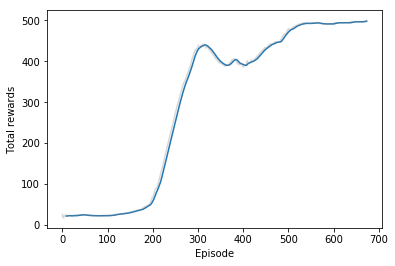

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

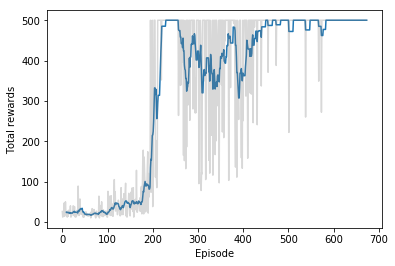

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

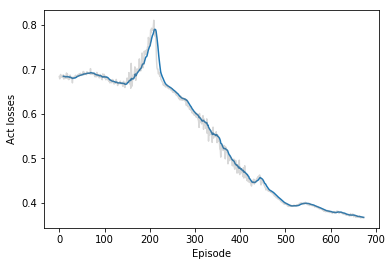

In [29]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

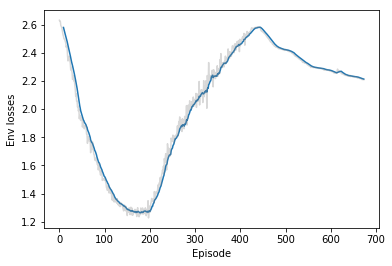

In [30]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

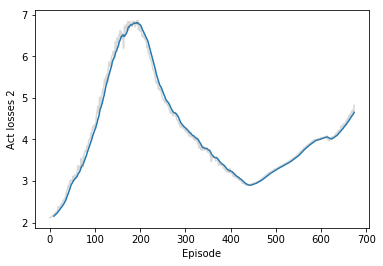

In [31]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [32]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 22.0
total_reward: 29.0
total_reward: 31.0
total_reward: 26.0
total_reward: 31.0
total_reward: 33.0
total_reward: 27.0
total_reward: 28.0
total_reward: 29.0
total_reward: 34.0
